In [170]:
import pybaseball as pyb
import pandas as pd
import time
import inspect
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch import optim
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import os
from featureranker.utils import *
from featureranker.plots import *
from featureranker.rankers import *
import glob
import numpy as np
from tqdm.auto import tqdm
import pickle
from sklearn import svm
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, ConfusionMatrixDisplay
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
import warnings
from sklearn.model_selection import KFold
warnings.filterwarnings('ignore')

pyb.cache.enable()
pyb.cache.config.cache_type='csv'
pyb.cache.config.save()

# Functions

# Importing Data

In [171]:

def bref_batter(date1,date2):
# Initialize a list to store all data
    all_data = []

# Loop over the years from the beginning year to the current year
    for year in range(date1, date2):  # Replace 2024 with the current year
        try:
            data = pyb.batting_stats_bref(year)
            print(f"Batter Data fetched for year: {year}")
            all_data.append(data)
        except Exception as e:
            print(f"An error occurred for year: {year}. Error: {str(e)}")
    

    time.sleep(4)
# Concatenate all dataframes in the list
    all_data_df = pd.concat(all_data)
    return all_data_df



def bref_pitcher(date1,date2):
# Initialize a list to store all data
    all_data = []

# Loop over the years from the beginning year to the current year
    for year in range(date1, date2):  # Replace 2024 with the current year
        try:
            data = pyb.pitching_stats_bref(year)
            print(f"Pitcher Data fetched for year: {year}")
            all_data.append(data)
        except Exception as e:
            print(f"An error occurred for year: {year}. Error: {str(e)}")
    

    time.sleep(4)
# Concatenate all dataframes in the list
    all_data_df = pd.concat(all_data)
    return all_data_df



def bref_fielder(date1,date2):
# Initialize a list to store all data
    all_data = []

# Loop over the years from the beginning year to the current year
    for year in range(date1, date2):  # Replace 2024 with the current year
        try:
            data = pyb.statcast_outs_above_average(year, "all", 0)
            print(f"Fielding Data fetched for year: {year}")
            all_data.append(data)
        except Exception as e:
            print(f"An error occurred for year: {year}. Error: {str(e)}")
    

    time.sleep(4)
# Concatenate all dataframes in the list
    all_data_df = pd.concat(all_data)
    return all_data_df



def per_game_data(date1,date2):
# Initialize a list to store all data
    all_data = []

# Loop over the years from the beginning year to the current year
    for year in range(date1, date2):  # Replace 2024 with the current year
        try:
            data = pyb.season_game_logs(year)
            print(f"Data fetched for year: {year}")
            all_data.append(data)
        except Exception as e:
            print(f"An error occurred for year: {year}. Error: {str(e)}")
# Concatenate all dataframes in the list
    all_data_df = pd.concat(all_data)
    return all_data_df




def Main_Scrape(date1,date2):

    batter_data=bref_batter(date1,date2)

    pitcher_data=bref_pitcher(date1,date2)

    fielder_data=bref_fielder(date1,date2)
    batter_data.to_csv('./Lahman_compiled_player_data/batter_data.csv', index=False)
    pitcher_data.to_csv('./Lahman_compiled_player_data/pitcher_data.csv', index=False)
    fielder_data.to_csv('./Lahman_compiled_player_data/fielder_data.csv', index=False)
    return batter_data,fielder_data,pitcher_data



def Main_Import(per_game_path,batter_path,pitcher_path,fielder_path):
    # Save the dataframes to csv files
    per_game_data=pd.read_csv(per_game_path, header=0)
    batter_data=pd.read_csv(batter_path, header=0)
    pitcher_data=pd.read_csv(pitcher_path, header=0)
    fielder_data=pd.read_csv(fielder_path, header=0)
    chad = pyb.chadwick_register(save=True)
    return batter_data,pitcher_data,fielder_data, per_game_data, chad

def fetch_data_bwar(date1, date2, per_game_path):
    import pybaseball as pyb
    import pandas as pd

    # fielder_data = bref_fielder(date1, date2)
    batter_bwar_data = pyb.bwar_bat()
    pitcher_bwar_data = pyb.bwar_pitch()
    per_game_data = pd.read_csv(per_game_path, header=0)
    chad = pyb.chadwick_register(save=True)
    # return fielder_data, batter_bwar_data, pitcher_bwar_data, per_game_data, chad
    return batter_bwar_data, pitcher_bwar_data, per_game_data, chad

# Formatting player data

In [172]:
#Remove columns with an NaN above a certain level
def remove_columns_with_nan(df, NaN_cutoff_percentage):
    NaN_cutoff = NaN_cutoff_percentage / 100.0
    return df.loc[:, df.isnull().mean() < NaN_cutoff]
from sklearn.preprocessing import LabelEncoder

#Turn columns with letters in them to numbers
def label_encode(df):
    le = LabelEncoder()
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = le.fit_transform(df[col])
    return df
    
#Turn mlbid into retro id
def process_dataframe(df, index_column, chad, chad_key_column, chad_value_column):
    df = df.set_index(index_column)
    chad_dict = chad.set_index(chad_key_column)[chad_value_column].to_dict()
    df.index = df.index.map(chad_dict)
    return df

# Formatting per game data

In [173]:
def process_per_game_data(per_game_data):
    # Create 'DateHmTmVisTm' column
    per_game_data['Game_ID'] = per_game_data['Date'].astype(str) + per_game_data['HmTm'] + per_game_data['VisTm']

    # Set the index to 'DateHmTmVisTm'
    # Reset the current index
    per_game_data = per_game_data.reset_index()

# Set the new index
    per_game_data.set_index('Game_ID', inplace=True)

    # List of columns to keep
    columns_to_keep = ['HmStPchID', 'VisStPchID', 'HmBat1ID', 'HmBat2ID', 'HmBat3ID', 'HmBat4ID', 'HmBat5ID', 'HmBat6ID', 'HmBat7ID', 'HmBat8ID', 'HmBat9ID', 'VisBat1ID', 'VisBat2ID', 'VisBat3ID', 'VisBat4ID', 'VisBat5ID', 'VisBat6ID', 'VisBat7ID', 'VisBat8ID', 'VisBat9ID', 'HmRuns', 'VisRuns']

    # Drop unnecessary columns
    per_game_data = per_game_data[columns_to_keep]

    # Create 'winner' column
    per_game_data['winner'] = np.where(per_game_data['HmRuns'] > per_game_data['VisRuns'], 1, 0)
    per_game_data['home_odds'] = -110
    per_game_data['visiting_odds']= -110
    
    return per_game_data

def process_player_data(per_game_data_reduced, player_id_columns, pitcher_bwar_encoded, batter_bwar_encoded):
    # Replace player_ids with their stats and add new columns for each stat
    for column in player_id_columns:
        if 'PchID' in column:  # If the column is for a pitcher
            stats = per_game_data_reduced[column].map(pitcher_bwar_encoded)
        else:  # If the column is for a batter
            stats = per_game_data_reduced[column].map(batter_bwar_encoded)

        # Add new columns for each stat
        for stat_name in stats.iloc[0].keys():
            per_game_data_reduced[column + '_' + stat_name] = stats.apply(lambda x: x[stat_name] if isinstance(x, dict) else np.nan)

        # Drop the original column
        per_game_data_reduced.drop(column, axis=1, inplace=True)
    
    return per_game_data_reduced

def split_data(per_game_data_reduced, train_year, test_year):
    # Create a mask for the training set
    train_mask = per_game_data_reduced.index.str.contains('|'.join(train_year))

    # Split the data into training and testing sets
    X_train = per_game_data_reduced[train_mask].drop(['winner','home_odds','visiting_odds','HmRuns','VisRuns'], axis=1)
    y_train = per_game_data_reduced.loc[train_mask, 'winner']

    # Create a mask for the test set
    test_mask = per_game_data_reduced.index.str.contains(test_year)

    X_test = per_game_data_reduced[test_mask].drop(['winner', 'home_odds','visiting_odds','HmRuns','VisRuns'], axis=1)
    y_test = per_game_data_reduced.loc[test_mask, 'winner']
    
    return X_train, y_train, X_test, y_test

def Impute(df, method):
    # Create an imputer instance
    imputer = SimpleImputer(strategy=method, fill_value=0)
    # Fit and transform all columns
    df[:] = imputer.fit_transform(df)
    return df

# Set-up Neural Network

In [174]:
class vector_dataset(Dataset):
    def __init__(self, X, y):
        self.X = np.array(X)
        self.y = np.array(y)

    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        vec = torch.tensor(self.X[idx], dtype=torch.float)
        label = torch.tensor(self.y[idx], dtype=torch.long)
        return vec, label


class neural_net(nn.Module):
    def __init__(self, input_size, hidden_size, hidden_num, output_size, dropout_rate):
        super(neural_net, self).__init__()
        self.gelu = nn.GELU()
        self.dropout = nn.Dropout(dropout_rate)
        self.hidden_num = hidden_num
        self.input_layer = nn.Linear(input_size, hidden_size)
        self.hidden_layers = nn.ModuleList()
        for i in range(hidden_num):
            self.hidden_layers.append(nn.Linear(hidden_size, hidden_size))
        self.output_layer = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.gelu(self.input_layer(x))
        x = self.dropout(x)
        for i in range(self.hidden_num):
            x = self.gelu(self.hidden_layers[i](x))
            x = self.dropout(x)
        x = self.output_layer(x)
        return x


#CHECK TO SEE HOW GOOD MODEL IS
def cross_validate(model, X, y, n_splits=5):
    kfold = KFold(n_splits=n_splits)
    scores = []

    for train_indices, valid_indices in kfold.split(X):
        # Split the data
        X_train, X_valid = X[train_indices], X[valid_indices]
        y_train, y_valid = y[train_indices], y[valid_indices]

        # Convert to PyTorch datasets
        train_dataset = vector_dataset(X_train, y_train)
        valid_dataset = vector_dataset(X_valid, y_valid)

        # Create data loaders
        train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
        valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

        # Define loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters())

        # Train the model on the training data
        model.train()
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Evaluate the model on the validation data
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in valid_loader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = correct / total
        scores.append(accuracy)

    return scores

#CALL THE MODEL
def train_and_evaluate_model(model, train_loader, test_loader, optimizer, criterion, patience=10, num_epochs=50):
    best_loss = float('inf')
    patience_counter = 0
    best_model_path = 'best_model.pth'  # File path for saving the best model

    for epoch in range(num_epochs):  # number of epochs
        model.train()
        train_losses = []
        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}'):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.squeeze())
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        avg_train_loss = np.mean(train_losses)
        print(f'Training Loss: {avg_train_loss}')

        model.eval()
        valid_losses = []
        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels.squeeze())
                valid_losses.append(loss.item())

        avg_valid_loss = np.mean(valid_losses)
        print(f'Validation Loss: {avg_valid_loss}')

        # Save the model at each epoch
        epoch_model_path = f'model_epoch_{epoch + 1}.pth'
        torch.save(model.state_dict(), epoch_model_path)

        # Update the best model if validation loss improves
        if avg_valid_loss < best_loss:
            best_loss = avg_valid_loss
            torch.save(model.state_dict(), best_model_path)
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print('Early stopping triggered')
                break

    # Load the best model
    model.load_state_dict(torch.load(best_model_path))

    # Evaluate the best model
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate confusion matrix and classification report
    conf_matrix = confusion_matrix(all_labels, all_preds)
    class_report = classification_report(all_labels, all_preds)
    print('Confusion Matrix:')
    print(conf_matrix)
    print('Classification Report:')
    print(class_report)


#Luck Accuracy calculation
def calculate_accuracy(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():  # No need to track gradients for this
        for inputs, labels in data_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)  # Get the index of the max log-probability
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    accuracy = correct_predictions / total_predictions
    return accuracy

# Predict the outcome of the season and calculate profit

In [175]:
class Better:
    def __init__(self, initial_wallet=1000):
        self.wallet = initial_wallet
        self.wallet_history = [initial_wallet]  # Store the initial wallet balance

    def bet(self, game_indices, bet_on_home_team, amount_bet, game_data):
        # Ensure the bettor has enough money in the wallet
        if amount_bet > self.wallet:
            print("Insufficient funds for this bet.")
            return

        # Retrieve the game data
        games = game_data.loc[game_indices]
        
        # If games is a DataFrame, iterate over its rows
        if isinstance(games, pd.DataFrame):
            game_iter = games.iterrows()
        else:  # If games is a Series (single row), create a one-item iterator
            game_iter = [(game_indices, games)]
        
        for _, game in game_iter:
            # Retrieve the odds
            home_odds = game['home_odds']
            away_odds = game['visiting_odds']
            
            # Determine the odds based on the team bet on
            odds = home_odds if bet_on_home_team else away_odds
            
            # Determine if the bet was a win or loss
            bet_won = (game['winner'] == bet_on_home_team)
            
            # Calculate the amount gained or lost
            if bet_won:
                if odds > 0:
                    # For positive odds, the gain is the odds * the amount bet / 100
                    gain = amount_bet * odds / 100
                else:
                    # For negative odds, the gain is the amount bet / (odds / -100)
                    gain = amount_bet / (odds / -100)
                self.wallet += gain
            else:
                # If the bet was lost, the loss is the amount bet
                self.wallet -= amount_bet

            # Store the new wallet balance
            self.wallet_history.append(self.wallet)

        return self.wallet
    
def predict_game_outcome(game_ids, game_data, model, augment=False, base_bet=100, scaler=1):
    num_games = len(game_ids)
    results, bets = [None]*num_games, [None]*num_games
    skipped = []
    for i in range(num_games):
        try:
            game_vector = torch.tensor([game_data[i]], dtype=torch.float)
            model.eval()
            with torch.no_grad():
                logits = model(game_vector)
                probs = logits.softmax(dim=-1)
                _, pred = torch.max(logits, 1)
                pred = pred.item()
                prob = probs[0][pred].item()
            results[i] = (game_ids[i], 'True' if pred else 'False')
            bets[i] = base_bet * prob * scaler if augment else base_bet
        except:
            skipped.append(i)
    return results, bets, skipped



Epoch 1: 100%|██████████| 242/242 [00:01<00:00, 233.23it/s]


Training Loss: 0.9362950290530181
Validation Loss: 0.6929123056562323


Epoch 2: 100%|██████████| 242/242 [00:01<00:00, 237.42it/s]


Training Loss: 0.7026885976968718
Validation Loss: 0.6921790602960085


Epoch 3: 100%|██████████| 242/242 [00:01<00:00, 232.34it/s]


Training Loss: 0.6929586923812047
Validation Loss: 0.6907514647433632


Epoch 4: 100%|██████████| 242/242 [00:01<00:00, 235.76it/s]


Training Loss: 0.688016268340024
Validation Loss: 0.6875270636458146


Epoch 5: 100%|██████████| 242/242 [00:01<00:00, 232.13it/s]


Training Loss: 0.6858482493841944
Validation Loss: 0.6868772773366225


Epoch 6: 100%|██████████| 242/242 [00:01<00:00, 232.65it/s]


Training Loss: 0.6838885474303538
Validation Loss: 0.6877915122007069


Epoch 7: 100%|██████████| 242/242 [00:01<00:00, 225.56it/s]


Training Loss: 0.683921713228068
Validation Loss: 0.686697792065771


Epoch 8: 100%|██████████| 242/242 [00:01<00:00, 235.26it/s]


Training Loss: 0.6831091529081675
Validation Loss: 0.6883889468092668


Epoch 9: 100%|██████████| 242/242 [00:01<00:00, 235.08it/s]


Training Loss: 0.6829906061661145
Validation Loss: 0.6860447918113909


Epoch 10: 100%|██████████| 242/242 [00:01<00:00, 239.52it/s]


Training Loss: 0.6830050538886677
Validation Loss: 0.6865143854367105


Epoch 11: 100%|██████████| 242/242 [00:01<00:00, 227.66it/s]


Training Loss: 0.6823795496924849
Validation Loss: 0.6864937245845795


Epoch 12: 100%|██████████| 242/242 [00:01<00:00, 223.36it/s]


Training Loss: 0.6815132104660854
Validation Loss: 0.6878730639031059


Epoch 13: 100%|██████████| 242/242 [00:01<00:00, 234.18it/s]


Training Loss: 0.682039467510113
Validation Loss: 0.6916430419997165


Epoch 14: 100%|██████████| 242/242 [00:01<00:00, 231.84it/s]


Training Loss: 0.6819060969451243
Validation Loss: 0.6855402777069494


Epoch 15: 100%|██████████| 242/242 [00:01<00:00, 230.68it/s]


Training Loss: 0.6814769794625685
Validation Loss: 0.6865296928506148


Epoch 16: 100%|██████████| 242/242 [00:01<00:00, 233.22it/s]


Training Loss: 0.6811855198923221
Validation Loss: 0.6934640611472883


Epoch 17: 100%|██████████| 242/242 [00:01<00:00, 228.71it/s]


Training Loss: 0.6797535894823469
Validation Loss: 0.6883883962505742


Epoch 18: 100%|██████████| 242/242 [00:01<00:00, 235.04it/s]


Training Loss: 0.6816576955732235
Validation Loss: 0.6853447650608263


Epoch 19: 100%|██████████| 242/242 [00:01<00:00, 234.44it/s]


Training Loss: 0.6808994417348184
Validation Loss: 0.6845730009831881


Epoch 20: 100%|██████████| 242/242 [00:01<00:00, 235.29it/s]


Training Loss: 0.6795481524684213
Validation Loss: 0.6881586313247681


Epoch 21: 100%|██████████| 242/242 [00:01<00:00, 223.78it/s]


Training Loss: 0.6801731741625415
Validation Loss: 0.6865623859982741


Epoch 22: 100%|██████████| 242/242 [00:01<00:00, 236.78it/s]


Training Loss: 0.6800078875269772
Validation Loss: 0.6843584634755787


Epoch 23: 100%|██████████| 242/242 [00:01<00:00, 231.09it/s]


Training Loss: 0.6786999333003336
Validation Loss: 0.6834117989791068


Epoch 24: 100%|██████████| 242/242 [00:01<00:00, 234.48it/s]


Training Loss: 0.6778946486878986
Validation Loss: 0.6849832832813263


Epoch 25: 100%|██████████| 242/242 [00:01<00:00, 234.81it/s]


Training Loss: 0.67881036420499
Validation Loss: 0.6949508111727866


Epoch 26: 100%|██████████| 242/242 [00:01<00:00, 224.62it/s]


Training Loss: 0.6784060235358467
Validation Loss: 0.6941647623714647


Epoch 27: 100%|██████████| 242/242 [00:01<00:00, 235.35it/s]


Training Loss: 0.6771087653873381
Validation Loss: 0.6845516311494928


Epoch 28: 100%|██████████| 242/242 [00:01<00:00, 231.71it/s]


Training Loss: 0.6766331656412645
Validation Loss: 0.6876910297494185


Epoch 29: 100%|██████████| 242/242 [00:01<00:00, 232.99it/s]


Training Loss: 0.6762716245552725
Validation Loss: 0.6871616009034609


Epoch 30: 100%|██████████| 242/242 [00:01<00:00, 226.80it/s]


Training Loss: 0.6751494380560789
Validation Loss: 0.688452356740048


Epoch 31: 100%|██████████| 242/242 [00:01<00:00, 217.55it/s]


Training Loss: 0.6746343381641325
Validation Loss: 0.6883027035939066


Epoch 32: 100%|██████████| 242/242 [00:01<00:00, 231.26it/s]


Training Loss: 0.674016817542147
Validation Loss: 0.6931178820760626


Epoch 33: 100%|██████████| 242/242 [00:01<00:00, 230.99it/s]


Training Loss: 0.6732627729739039
Validation Loss: 0.6878115346557215
Early stopping triggered
Confusion Matrix:
[[407 745]
 [353 924]]
Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.35      0.43      1152
           1       0.55      0.72      0.63      1277

    accuracy                           0.55      2429
   macro avg       0.54      0.54      0.53      2429
weighted avg       0.55      0.55      0.53      2429

3217.180645574227


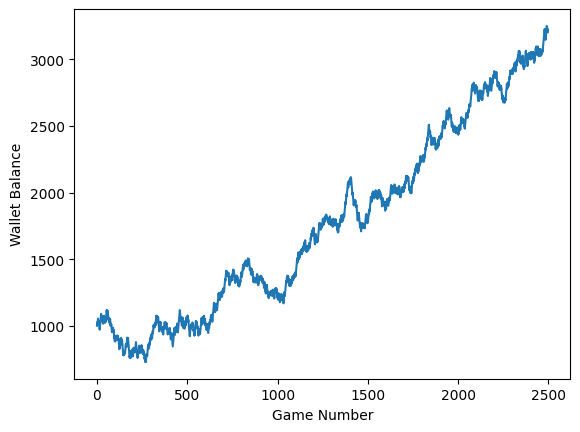

728.4284919500359


In [176]:
#Training and testing years for the machine learning model
test_year = '2011'
train_year = [str(year) for year in range(int(test_year) - 6, int(test_year))]


#Use this to update data from the websites (has data starting from 2008)
date1=2008
date2=2024

#Do not use this unless you want to go back to the old data
# batter_data,pitcher_data,fielder_data=Main_Scrape(2008,2024)

# get the register data and save to disk


#After scraping the files are saved locally. Also, the per_game_data is found manually and imported
per_game_path='./pybaseball/pybaseball/data/Lahman_MLB_per_game_data.csv'
batter_path='./Lahman_compiled_player_data/batter_data.csv'
pitcher_path='./Lahman_compiled_player_data/pitcher_data.csv'
fielder_path='./Lahman_compiled_player_data/fielder_data.csv'
# _,_,fielder_data, per_game_data, chad = Main_Import(per_game_path,batter_path,pitcher_path,fielder_path)


#New Bwar data scraping
# fielder_data, batter_bwar_data, pitcher_bwar_data, per_game_data, chad = fetch_data_bwar(date1, date2, per_game_path)
batter_bwar_data, pitcher_bwar_data, per_game_data, chad = fetch_data_bwar(date1, date2, per_game_path)

# Use the function to remove columns with more than 40% NaN values
batter_bwar_data = remove_columns_with_nan(batter_bwar_data, 40)
pitcher_bwar_data = remove_columns_with_nan(pitcher_bwar_data, 40)
# fielder_data = remove_columns_with_nan(fielder_data, 40)

batter_bwar_data = process_dataframe(batter_bwar_data, 'mlb_ID', chad, 'key_mlbam', 'key_retro')
pitcher_bwar_data = process_dataframe(pitcher_bwar_data, 'mlb_ID', chad, 'key_mlbam', 'key_retro')
# fielder_data = process_dataframe(fielder_data, 'player_id', chad, 'key_mlbam', 'key_retro')

batter_bwar_encoded = label_encode(batter_bwar_data)
batter_bwar_grouped = batter_bwar_encoded.groupby('mlb_ID').mean()
batter_bwar_reduced=batter_bwar_grouped.drop(columns=['lg_ID','stint_ID','year_ID','name_common','player_ID','pitcher'])
batter_bwar_dict = batter_bwar_reduced.T.to_dict()


pitcher_bwar_encoded = label_encode(pitcher_bwar_data)
pitcher_bwar_grouped = pitcher_bwar_encoded.groupby('mlb_ID').mean()
pitcher_bwar_reduced=pitcher_bwar_grouped.drop(columns=['lg_ID','stint_ID','year_ID','name_common','player_ID'])
pitcher_bwar_dict = pitcher_bwar_reduced.T.to_dict()
# fielder_encoded = fielder_encoded.T.to_dict()

#Drops unnecessary columns
per_game_data_reduced = process_per_game_data(per_game_data)
test_purposes=process_per_game_data(per_game_data)
# List of columns containing player_ids
player_id_columns = ['HmStPchID', 'VisStPchID', 'HmBat1ID', 'HmBat2ID', 'HmBat3ID', 'HmBat4ID', 'HmBat5ID', 'HmBat6ID', 'HmBat7ID', 'HmBat8ID', 'HmBat9ID', 'VisBat1ID', 'VisBat2ID', 'VisBat3ID', 'VisBat4ID', 'VisBat5ID', 'VisBat6ID', 'VisBat7ID', 'VisBat8ID', 'VisBat9ID']


#replaces player_ids with their player_stats
# for_test_purposes = process_player_data(per_game_data_reduced, player_id_columns, pitcher_bwar_encoded, batter_bwar_encoded)
per_game_data_reduced = process_player_data(per_game_data_reduced, player_id_columns, pitcher_bwar_dict, batter_bwar_dict)
test_purposes = process_player_data(test_purposes, player_id_columns, pitcher_bwar_dict, batter_bwar_dict)
#Removes columns with more than 40%
per_game_data_reduced = remove_columns_with_nan(per_game_data_reduced, 40)
#replaces nan with 0s

per_game_data_imputed=Impute(per_game_data_reduced,'mean')

#splits the data into 
X_train, y_train, X_test, y_test = split_data(per_game_data_imputed, train_year, test_year)

#my code is bad so the model needs to be called again after the cross validater
model = neural_net(X_train.shape[1], X_train.shape[1]*2, 2, 2, 0.15)


# print("Cross-validation scores: ", scores)
# print("Cross-validation scores average: ", np.mean(scores))
# print("Standard deviation of cross-validation score: ", np.std(scores))
# model = neural_net(X_train.shape[1], X_train.shape[1]*2, 2, 2, 0.15)

train_dataset = vector_dataset(X_train, y_train)
test_dataset = vector_dataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# optimizer = optim.Adam(model.parameters(), lr=0.0005)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.CrossEntropyLoss()

train_and_evaluate_model(model, train_loader, test_loader, optimizer, criterion)





ok, bets, skipped = predict_game_outcome(X_test.index, X_test.values, model, True, 10, 3)

better = Better()  # Create a Bettor instance with an initial wallet of 1000
# for game_id, bet_on_home_team in ok:
#     better.bet(game_id, bet_on_home_team == 'True', bets, per_game_data_imputed)
for (game_id, bet_on_home_team), amount_bet in zip(ok, bets):
    better.bet(game_id, bet_on_home_team == 'True', amount_bet, per_game_data_imputed)

print(better.wallet)
# Plot the wallet balance over time
plt.plot(better.wallet_history)
plt.xlabel('Game Number')
plt.ylabel('Wallet Balance')
plt.show()
print(min(better.wallet_history))


In [177]:
print(bets)

[15.192022919654846, 15.242486000061035, 18.38234782218933, 15.062888860702515, 15.879984498023987, 18.10943841934204, 16.525481343269348, 16.740716099739075, 15.15955924987793, 15.546648502349854, 16.35767161846161, 15.478198528289795, 16.02165699005127, 15.373358130455017, 17.070066332817078, 15.77111005783081, 16.891483068466187, 16.12153172492981, 16.372132301330566, 16.826578974723816, 15.604882836341858, 17.173814177513123, 15.975083112716675, 15.909202694892883, 15.577772855758667, 16.176039576530457, 15.118866562843323, 18.075242042541504, 16.52164399623871, 17.295745611190796, 15.256224274635315, 15.563489198684692, 18.925804495811462, 16.346958875656128, 15.04778802394867, 15.076110363006592, 15.874359011650085, 17.134907841682434, 15.777731537818909, 15.153100490570068, 15.93127191066742, 18.054953813552856, 16.875414848327637, 15.007944703102112, 15.824174880981445, 17.054007053375244, 15.353938937187195, 17.258818745613098, 16.56596839427948, 16.729100346565247, 19.2324739

In [178]:
test_accuracy = calculate_accuracy(model, test_loader)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

Test Accuracy: 54.80%


In [179]:

pd.set_option('display.max_columns', None)
test_purposes.head(1)

,HmRuns,VisRuns,winner,home_odds,visiting_odds,HmStPchID_team_ID,HmStPchID_G,HmStPchID_GS,HmStPchID_RA,HmStPchID_xRA,HmStPchID_BIP,HmStPchID_BIP_perc,HmStPchID_ERA_plus,HmStPchID_WAR_rep,HmStPchID_WAA,HmStPchID_WAA_adj,HmStPchID_WAR,VisStPchID_team_ID,VisStPchID_G,VisStPchID_GS,VisStPchID_RA,VisStPchID_xRA,VisStPchID_BIP,VisStPchID_BIP_perc,VisStPchID_ERA_plus,VisStPchID_WAR_rep,VisStPchID_WAA,VisStPchID_WAA_adj,VisStPchID_WAR,HmBat1ID_team_ID,HmBat1ID_G,HmBat1ID_PA,HmBat1ID_runs_above_avg,HmBat1ID_runs_above_avg_off,HmBat1ID_runs_above_avg_def,HmBat1ID_WAR_rep,HmBat1ID_WAA,HmBat1ID_WAR,HmBat2ID_team_ID,HmBat2ID_G,HmBat2ID_PA,HmBat2ID_runs_above_avg,HmBat2ID_runs_above_avg_off,HmBat2ID_runs_above_avg_def,HmBat2ID_WAR_rep,HmBat2ID_WAA,HmBat2ID_WAR,HmBat3ID_team_ID,HmBat3ID_G,HmBat3ID_PA,HmBat3ID_runs_above_avg,HmBat3ID_runs_above_avg_off,HmBat3ID_runs_above_avg_def,HmBat3ID_WAR_rep,HmBat3ID_WAA,HmBat3ID_WAR,HmBat4ID_team_ID,HmBat4ID_G,HmBat4ID_PA,HmBat4ID_runs_above_avg,HmBat4ID_runs_above_avg_off,HmBat4ID_runs_above_avg_def,HmBat4ID_WAR_rep,HmBat4ID_WAA,HmBat4ID_WAR,HmBat5ID_team_ID,HmBat5ID_G,HmBat5ID_PA,HmBat5ID_runs_above_avg,HmBat5ID_runs_above_avg_off,HmBat5ID_runs_above_avg_def,HmBat5ID_WAR_rep,HmBat5ID_WAA,HmBat5ID_WAR,HmBat6ID_team_ID,HmBat6ID_G,HmBat6ID_PA,HmBat6ID_runs_above_avg,HmBat6ID_runs_above_avg_off,HmBat6ID_runs_above_avg_def,HmBat6ID_WAR_rep,HmBat6ID_WAA,HmBat6ID_WAR,HmBat7ID_team_ID,HmBat7ID_G,HmBat7ID_PA,HmBat7ID_runs_above_avg,HmBat7ID_runs_above_avg_off,HmBat7ID_runs_above_avg_def,HmBat7ID_WAR_rep,HmBat7ID_WAA,HmBat7ID_WAR,HmBat8ID_team_ID,HmBat8ID_G,HmBat8ID_PA,HmBat8ID_runs_above_avg,HmBat8ID_runs_above_avg_off,HmBat8ID_runs_above_avg_def,HmBat8ID_WAR_rep,HmBat8ID_WAA,HmBat8ID_WAR,HmBat9ID_team_ID,HmBat9ID_G,HmBat9ID_PA,HmBat9ID_runs_above_avg,HmBat9ID_runs_above_avg_off,HmBat9ID_runs_above_avg_def,HmBat9ID_WAR_rep,HmBat9ID_WAA,HmBat9ID_WAR,VisBat1ID_team_ID,VisBat1ID_G,VisBat1ID_PA,VisBat1ID_runs_above_avg,VisBat1ID_runs_above_avg_off,VisBat1ID_runs_above_avg_def,VisBat1ID_WAR_rep,VisBat1ID_WAA,VisBat1ID_WAR,VisBat2ID_team_ID,VisBat2ID_G,VisBat2ID_PA,VisBat2ID_runs_above_avg,VisBat2ID_runs_above_avg_off,VisBat2ID_runs_above_avg_def,VisBat2ID_WAR_rep,VisBat2ID_WAA,VisBat2ID_WAR,VisBat3ID_team_ID,VisBat3ID_G,VisBat3ID_PA,VisBat3ID_runs_above_avg,VisBat3ID_runs_above_avg_off,VisBat3ID_runs_above_avg_def,VisBat3ID_WAR_rep,VisBat3ID_WAA,VisBat3ID_WAR,VisBat4ID_team_ID,VisBat4ID_G,VisBat4ID_PA,VisBat4ID_runs_above_avg,VisBat4ID_runs_above_avg_off,VisBat4ID_runs_above_avg_def,VisBat4ID_WAR_rep,VisBat4ID_WAA,VisBat4ID_WAR,VisBat5ID_team_ID,VisBat5ID_G,VisBat5ID_PA,VisBat5ID_runs_above_avg,VisBat5ID_runs_above_avg_off,VisBat5ID_runs_above_avg_def,VisBat5ID_WAR_rep,VisBat5ID_WAA,VisBat5ID_WAR,VisBat6ID_team_ID,VisBat6ID_G,VisBat6ID_PA,VisBat6ID_runs_above_avg,VisBat6ID_runs_above_avg_off,VisBat6ID_runs_above_avg_def,VisBat6ID_WAR_rep,VisBat6ID_WAA,VisBat6ID_WAR,VisBat7ID_team_ID,VisBat7ID_G,VisBat7ID_PA,VisBat7ID_runs_above_avg,VisBat7ID_runs_above_avg_off,VisBat7ID_runs_above_avg_def,VisBat7ID_WAR_rep,VisBat7ID_WAA,VisBat7ID_WAR,VisBat8ID_team_ID,VisBat8ID_G,VisBat8ID_PA,VisBat8ID_runs_above_avg,VisBat8ID_runs_above_avg_off,VisBat8ID_runs_above_avg_def,VisBat8ID_WAR_rep,VisBat8ID_WAA,VisBat8ID_WAR,VisBat9ID_team_ID,VisBat9ID_G,VisBat9ID_PA,VisBat9ID_runs_above_avg,VisBat9ID_runs_above_avg_off,VisBat9ID_runs_above_avg_def,VisBat9ID_WAR_rep,VisBat9ID_WAA,VisBat9ID_WAR
Game_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
20000329NYNCHN,3,5,0,-110,-110,57.9375,26.1875,22.1875,72.3125,74.440812,467.875,0.1038,104.985911,1.204381,0.197819,-0.110419,1.291875,99.0,28.642857,23.357143,82.714286,83.625571,519.5,0.116971,103.078375,1.354736,0.574321,-0.107229,1.821429,118.724138,106.241379,460.206897,23.103448,20.87931,-1.124138,1.457586,2.375172,3.832759,107.466667,88.533333,3

In [180]:
scores = cross_validate(model, X_train.values, y_train.values)
print("Cross-validation scores: ", scores)
print("Cross-validation scores average: ", np.mean(scores))
print("Standard deviation of cross-validation score: ", np.std(scores))

Cross-validation scores:  [0.561046511627907, 0.5655684754521964, 0.5654281098546042, 0.5534733441033926, 0.582875605815832]
Cross-validation scores average:  0.5656784093707865
Standard deviation of cross-validation score:  0.00965646307677486


In [181]:
X_test

,HmStPchID_team_ID,HmStPchID_G,HmStPchID_GS,HmStPchID_RA,HmStPchID_xRA,HmStPchID_BIP,HmStPchID_BIP_perc,HmStPchID_ERA_plus,HmStPchID_WAR_rep,HmStPchID_WAA,HmStPchID_WAA_adj,HmStPchID_WAR,VisStPchID_team_ID,VisStPchID_G,VisStPchID_GS,VisStPchID_RA,VisStPchID_xRA,VisStPchID_BIP,VisStPchID_BIP_perc,VisStPchID_ERA_plus,VisStPchID_WAR_rep,VisStPchID_WAA,VisStPchID_WAA_adj,VisStPchID_WAR,HmBat1ID_team_ID,HmBat1ID_G,HmBat1ID_PA,HmBat1ID_runs_above_avg,HmBat1ID_runs_above_avg_off,HmBat1ID_runs_above_avg_def,HmBat1ID_WAR_rep,HmBat1ID_WAA,HmBat1ID_WAR,HmBat2ID_team_ID,HmBat2ID_G,HmBat2ID_PA,HmBat2ID_runs_above_avg,HmBat2ID_runs_above_avg_off,HmBat2ID_runs_above_avg_def,HmBat2ID_WAR_rep,HmBat2ID_WAA,HmBat2ID_WAR,HmBat3ID_team_ID,HmBat3ID_G,HmBat3ID_PA,HmBat3ID_runs_above_avg,HmBat3ID_runs_above_avg_off,HmBat3ID_runs_above_avg_def,HmBat3ID_WAR_rep,HmBat3ID_WAA,HmBat3ID_WAR,HmBat4ID_team_ID,HmBat4ID_G,HmBat4ID_PA,HmBat4ID_runs_above_avg,HmBat4ID_runs_above_avg_off,HmBat4ID_runs_above_avg_def,HmBat4ID_WAR_rep,HmBat4ID_WAA,HmBat4ID_WAR,HmBat5ID_team_ID,HmBat5ID_G,HmBat5ID_PA,HmBat5ID_runs_above_avg,HmBat5ID_runs_above_avg_off,HmBat5ID_runs_above_avg_def,HmBat5ID_WAR_rep,HmBat5ID_WAA,HmBat5ID_WAR,HmBat6ID_team_ID,HmBat6ID_G,HmBat6ID_PA,HmBat6ID_runs_above_avg,HmBat6ID_runs_above_avg_off,HmBat6ID_runs_above_avg_def,HmBat6ID_WAR_rep,HmBat6ID_WAA,HmBat6ID_WAR,HmBat7ID_team_ID,HmBat7ID_G,HmBat7ID_PA,HmBat7ID_runs_above_avg,HmBat7ID_runs_above_avg_off,HmBat7ID_runs_above_avg_def,HmBat7ID_WAR_rep,HmBat7ID_WAA,HmBat7ID_WAR,HmBat8ID_team_ID,HmBat8ID_G,HmBat8ID_PA,HmBat8ID_runs_above_avg,HmBat8ID_runs_above_avg_off,HmBat8ID_runs_above_avg_def,HmBat8ID_WAR_rep,HmBat8ID_WAA,HmBat8ID_WAR,HmBat9ID_team_ID,HmBat9ID_G,HmBat9ID_PA,HmBat9ID_runs_above_avg,HmBat9ID_runs_above_avg_off,HmBat9ID_runs_above_avg_def,HmBat9ID_WAR_rep,HmBat9ID_WAA,HmBat9ID_WAR,VisBat1ID_team_ID,VisBat1ID_G,VisBat1ID_PA,VisBat1ID_runs_above_avg,VisBat1ID_runs_above_avg_off,VisBat1ID_runs_above_avg_def,VisBat1ID_WAR_rep,VisBat1ID_WAA,VisBat1ID_WAR,VisBat2ID_team_ID,VisBat2ID_G,VisBat2ID_PA,VisBat2ID_runs_above_avg,VisBat2ID_runs_above_avg_off,VisBat2ID_runs_above_avg_def,VisBat2ID_WAR_rep,VisBat2ID_WAA,VisBat2ID_WAR,VisBat3ID_team_ID,VisBat3ID_G,VisBat3ID_PA,VisBat3ID_runs_above_avg,VisBat3ID_runs_above_avg_off,VisBat3ID_runs_above_avg_def,VisBat3ID_WAR_rep,VisBat3ID_WAA,VisBat3ID_WAR,VisBat4ID_team_ID,VisBat4ID_G,VisBat4ID_PA,VisBat4ID_runs_above_avg,VisBat4ID_runs_above_avg_off,VisBat4ID_runs_above_avg_def,VisBat4ID_WAR_rep,VisBat4ID_WAA,VisBat4ID_WAR,VisBat5ID_team_ID,VisBat5ID_G,VisBat5ID_PA,VisBat5ID_runs_above_avg,VisBat5ID_runs_above_avg_off,VisBat5ID_runs_above_avg_def,VisBat5ID_WAR_rep,VisBat5ID_WAA,VisBat5ID_WAR,VisBat6ID_team_ID,VisBat6ID_G,VisBat6ID_PA,VisBat6ID_runs_above_avg,VisBat6ID_runs_above_avg_off,VisBat6ID_runs_above_avg_def,VisBat6ID_WAR_rep,VisBat6ID_WAA,VisBat6ID_WAR,VisBat7ID_team_ID,VisBat7ID_G,VisBat7ID_PA,VisBat7ID_runs_above_avg,VisBat7ID_runs_above_avg_off,VisBat7ID_runs_above_avg_def,VisBat7ID_WAR_rep,VisBat7ID_WAA,VisBat7ID_WAR,VisBat8ID_team_ID,VisBat8ID_G,VisBat8ID_PA,VisBat8ID_runs_above_avg,VisBat8ID_runs_above_avg_off,VisBat8ID_runs_above_avg_def,VisBat8ID_WAR_rep,VisBat8ID_WAA,VisBat8ID_WAR,VisBat9ID_team_ID,VisBat9ID_G,VisBat9ID_PA,VisBat9ID_runs_above_avg,VisBat9ID_runs_above_avg_off,VisBat9ID_runs_above_avg_def,VisBat9ID_WAR_rep,VisBat9ID_WAA,VisBat9ID_WAR
Game_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
20110331CINMIL,110.625000,18.375000,17.062500,51.812500,47.099438,291.437500,0.066450,86.927993,0.876481,-0.381725,-0.061137,0.434375,101.230769,24.538462,23.615385,67.538462,67.208923,420.923077,0.095192,104.840765,1.251592,0.303815,-0.076062,1.479231,68.000000,75.916667,263.916667,-1.375000,0.050000,-0.725000,0.820000,-0.159167,0.660833,43.555556,105.666667,444.000000,2.638889,1.561111,3.850000,1.3600

In [182]:
view_data(per_game_data_reduced)

There are no NaN values in the dataset
